In [1]:
%load_ext autoreload
%autoreload 2

# Figure 1a.

# Figure 1c.

In [13]:
import sys
sys.path.append('./scripts/')
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.decomposition import PCA
cmap = cm.RdYlGn_r

import conf
from clustering import generate_hierarchy, draw_flat_cluster
from retrieve import get_shaps

In [3]:
df_stats = pd.read_csv(conf.cohorts_path, sep="\t")

# mapping MoA colors to each (gene, ttype)

dg = pd.read_csv(conf.drivers_path, sep='\t')
d = dict(zip(zip(dg.SYMBOL, dg.CANCER_TYPE), map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))
d_gene = dict(zip(dg.SYMBOL, map(lambda x: conf.dict_colors_role.get(x, '#808080'), dg.ROLE)))

# load observed mutations

mutations = pd.read_csv(os.path.join(conf.output_boostdm, 'discovery', 'mutations.tsv'), sep='\t')

df = get_shaps(mutations, None, None)

In [18]:
def low_rank(gene, ttype):
    
    df = get_shaps(mutations, None, None)
    
    moa_colors = df['moa'].values
    complexity_colors = df['linear_complexity'].values
    
    df = df[conf.features]
    pca = PCA(10, whiten=True)
    projected = pca.fit_transform(df)
    return df, projected, moa_colors, complexity_colors


def cluster_heatmap(gene, ttype, mode='flat', labels=None, title=None, fn=None):
    
    df, projected, moa_colors, complexity_colors = low_rank(gene, ttype)
    X, linkage, scores, classes, labels_list = generate_hierarchy(df)
    if mode == 'flat':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', mode=mode, title=title, fn=fn)
    elif mode == 'moa':
        draw_flat_cluster(X, linkage, df.columns, labels_list[2], 
                          './raw_plots', moa_colors=moa_colors,
                          mode=mode, title=title, fn=fn)
    return labels_list[2]


 62%|██████▏   | 155/249 [01:30<00:53,  1.75it/s]


100%|██████████| 249/249 [02:25<00:00,  1.59it/s]


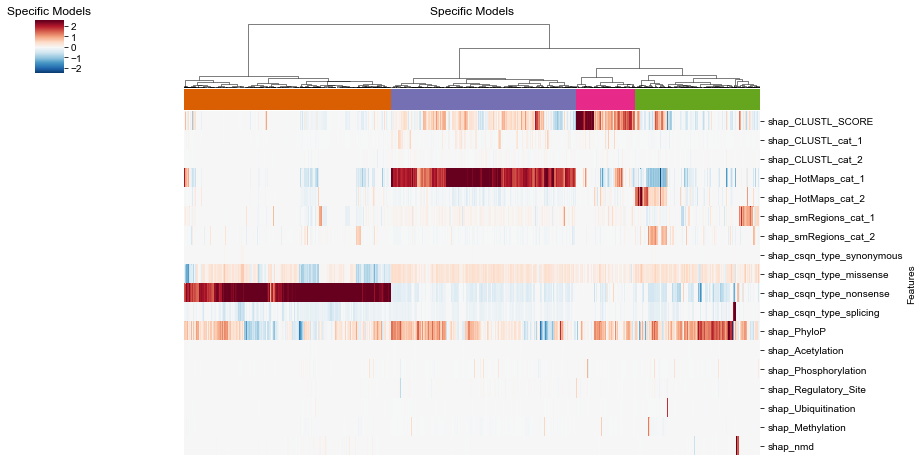

In [16]:
# unique observed mutations 
# per gene-ttype
# covered by specific models 
# with boostDM positive

labels_hierarchical = cluster_heatmap(None, None, mode='flat', 
                                      title='Specific Models', 
                                      fn='observed.specific.driver.hierarchy')


 62%|██████▏   | 155/249 [01:32<00:54,  1.71it/s]


100%|██████████| 249/249 [02:31<00:00,  1.52it/s]


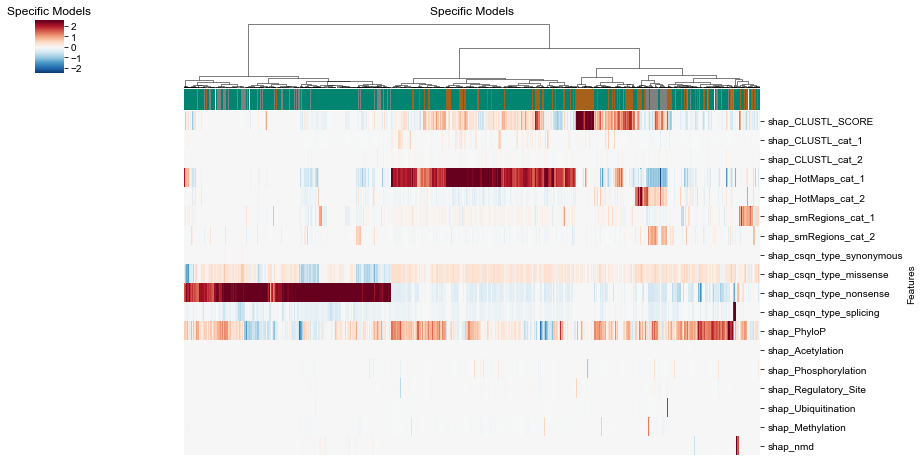

In [17]:
l = cluster_heatmap(None, None, mode='moa', title='Specific Models', fn='observed.specific.driver.moa')